In [2]:
import numpy as np
import scipy as sp
import scipy.linalg as sl
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import time
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [3]:
matplotlib.rcParams.update({'font.size': 22})
import semsetup as sem

In [5]:
import pyamg
from pyamg.krylov import gmres

In [6]:
class bc1d:
    def __init__(self,l,r):
        self.l = l
        self.r = r
        self.bcvl = 0.
        self.bcvr = 0.
        
    def __repr__(self):
        return "<BC 1D l:(%s,%f) r:(%s,%f)>" % (self.l,self.bcvl,self.r,self.bcvr)

    def __str__(self):
        return "left(l) is (%s,%f), right(r) is (%s,%f)"\
              % (self.l,self.bcvl,self.r,self.bcvr)
        
    def setdbc(self,loc,dbc):
        if(loc=='l'):
            self.l = 'd'
            self.bcvl = dbc
        elif(loc=='r'):
            self.r = 'd'
            self.bcvr = dbc
            
    def setrbc(self,loc,rbc):
        if(loc=='l'):
            self.l = 'R'
            self.bcvl = rbc
        elif(loc=='r'):
            self.r = 'R'
            self.bcvr = rbc
            
    def setnbc(self,loc,nbc):
        if(loc=='l'):
            self.l = 'n'
            self.bcvl = nbc
        elif(loc=='r'):
            self.r = 'n'
            self.bcvr = nbc
    
    def tostr(self):
        return "%s%s" %(self.l,self.r)

class bc2d():
    def __init__(self,xl,xr,yl,yr):
        self.x = bc1d(xl,xr)
        self.y = bc1d(yl,yr)
        
    def __repr__(self):
        return "<BC 2D: x - %s,%s; y - %s,%s>" % (self.x.l, self.x.r, self.y.l, self.y.r)

    def __str__(self):
        return "2D Boundary conditions: \n x: %s\n y: %s\n" % (repr(self.x), repr(self.y))
        
    def setdbc(self,drc,loc,dbc):
        if(drc=='x'):
            self.x.setdbc(loc,dbc)
        elif(drc=='y'):
            self.y.setdbc(loc,dbc)
    
    def setrbc(self,drc,loc,rbc):
        if(drc=='x'):
            self.x.setrbc(loc,rbc)
        elif(drc=='y'):
            self.y.setrbc(loc,rbc)
            
    def setnbc(self,drc,loc,dbc):
        if(drc=='x'):
            self.x.setnbc(loc,dbc)
        elif(drc=='y'):
            self.y.setnbc(loc,dbc)
    
    def tostr(self):
        return '%s%s%s%s'%(self.x.l,self.x.r,self.y.l,self.y.r)

In [7]:
def sem_adflocop(A,B,D,cx,cy,nu,lxe,lye):
    '''SEM adf operator, local, one element'''
    A2 = nu * ((lye/lxe)*sparse.kron(B,A) + (lxe/lye)*sparse.kron(A,B)).tocsr()
    Ih = sparse.eye(D.shape[0])
    C2 =  sparse.kron(B,B)\
      * ( (lye/2.)*sparse.diags(cx.reshape((-1,),order='F'))*sparse.kron(Ih,D)\
        + (lxe/2.)*sparse.diags(cy.reshape((-1,),order='F'))*sparse.kron(D,Ih))
    L = A2 + C2 # Adv-diff
    B2 = (lxe*lye/4.)*sparse.kron(B,B).tocsr()
    return A2,B2,C2,L

def sem_adfglbop(p,Ex,Ey,cx,cy,nu,lxe,lye):
    '''SEM adf Global Operator, Elem based
    cx, cy: (p+1,p+1,Ex*Ey)'''
    (ah,bh,ch,dh,z,w) = sem.semhat(p)
    nl = p+1
    Lrow, Lcol, Ldata = ([] for i in range(3))
    Brow, Bcol, Bdata = ([] for i in range(3))
    i = 0
    for e in range(Ex*Ey):
        Ae,Be,Ce,Le = sem_adflocop(ah,bh,dh,cx[:,:,e],cy[:,:,e],nu,lxe,lye)
        Lnz = Le.nonzero()
        sparserows = Lnz[0]
        sparsecols = Lnz[1]
        Lrow.extend(np.reshape(sparserows+int(i),-1).tolist())
        Lcol.extend(np.reshape(sparsecols+int(i),-1).tolist())
        Ldata.extend(np.reshape(Le.data,-1).tolist())
        Bnz = Be.nonzero()
        sparserows = Bnz[0]
        sparsecols = Bnz[1]
        Brow.extend((sparserows+int(i)).tolist())
        Bcol.extend((sparsecols+int(i)).tolist())
        Bdata.extend(np.reshape(Be[sparserows,:][:,sparsecols].data,-1).tolist())
        i = i + nl*nl
        
    Ldata = np.array(Ldata)
    Lcol  = np.array(Lcol)
    Lrow  = np.array(Lrow)
    Lge   = sparse.csr_matrix((Ldata, (Lrow, Lcol)),shape=(nl*nl*Ex*Ey,nl*nl*Ex*Ey))

    Bdata = np.array(Bdata)
    Bcol  = np.array(Bcol)
    Brow  = np.array(Brow)
    Bge   = sparse.csr_matrix((np.array(Bdata), (np.array(Brow), np.array(Bcol))),shape=(nl*nl*Ex*Ey,nl*nl*Ex*Ey))
    return Lge, Bge

In [8]:
def ldir2elem(Al,nl,Ex,Ey):
    '''directional array to element based
    input:  Al(nl*Ex,nl*Ey)
    output: Ae(nl,nl,Ex*Ey)
    '''
    if(Al.shape!=(nl*Ex,nl*Ey)):
        print('Wrong input matrix shape! Input shape: %s; Assumed shape: %s\n'%(Al.shape,(nl*Ex,nl*Ey)))
        return None
    Ae = np.zeros((nl,nl,Ex,Ey),order='F',dtype=Al.dtype)
    for je in range(Ey):
        for ie in range(Ex):
            for j in range(nl):
                for i in range(nl):
                    it = i + (ie)*nl
                    jt = j + (je)*nl
                    # print(i,j,ie,je,it,jt,cxl[it,jt])
                    Ae[i,j,ie,je] = Al[it,jt]
    Ae = Ae.reshape((nl,nl,Ex*Ey),order='F')
    return Ae

def elem2ldir(Ae,nl,Ex,Ey):
    '''element based array to directional based
    input:  Ae(nl,nl,Ex*Ey)
    output: Al(nl*Ex,nl*Ey)
    '''
    if(Ae.shape!=(nl,nl,Ex*Ey)):
        print('Wrong input matrix shape! Input shape: %s; Assumed shape: %s\n'%(Ae.shape,(nl,nl,Ex*Ey)))
        return None
    Al = np.zeros((nl*Ex,nl*Ey),order='F',dtype=Ae.dtype)
    for je in range(Ey):
        for ie in range(Ex):
            for j in range(nl):
                for i in range(nl):
                    it = i + (ie)*nl
                    jt = j + (je)*nl
                    et = ie + (je)*Ex
                    
                    Al[it,jt] = Ae[i,j,et]
    # Al = Al.reshape((nl*Ex,nl*Ey),order='F')
    return Al

def genperm(nl,Ex,Ey):
    '''Generate Permutation indices for elem based vector to appear as dir based vector'''
    inddir = np.arange(nl*Ex*nl*Ey,dtype=int).reshape((nl*Ex,nl*Ey),order='F')
    indelm = ldir2elem(inddir,nl,Ex,Ey)
    indnew = indelm.reshape(-1,order='F')
    Perm = np.argsort(indnew,axis=0)
    if(sl.norm(inddir.reshape(-1,order='F') - indnew[Perm],2)>1e-10):
        print('Error in genperm')
        return None
    # generate permutation indices from dir based vector to elem based
    indelm = np.arange(nl*nl*Ex*Ey,dtype=int).reshape((nl,nl,Ex*Ey),order='F')
    inddir = elem2ldir(indelm,nl,Ex,Ey)
    indnew = inddir.reshape(-1,order='F')
    Perm2 = np.argsort(indnew,axis=0)
    if(sl.norm(indelm.reshape(-1,order='F') - indnew[Perm2],2)>1e-10):
        print("Error in genperm for Perm2")
        return None
    return Perm,Perm2

In [9]:
def sempltsurf(X,Y,U,cx,cy,xyrot=225):
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(X,Y,U,cmap=cm.jet)
    ax.set_xlabel('$x$',labelpad=20)
    ax.set_ylabel('$y$',labelpad=20)
    ax.set_zlabel('$u$',labelpad=10)
    ax.view_init(30, xyrot)
    ax2 = fig.add_subplot(122)
    ax2.quiver(X,Y,cx,cy)
    return 0

In [10]:
def fidtovid(fid,nl):
    if(fid==0): # x, left
        nd = np.linspace(0,nl*(nl-1),nl,dtype=int)
    if(fid==1): # x, right
        nd = np.linspace(nl-1,nl*nl-1,nl,dtype=int)
    if(fid==2): # y, left (bottom)    
        nd = np.arange(nl)
    if(fid==3): # y, right (top)
        nd = np.arange(nl*(nl-1),nl*nl)
    return nd

In [11]:
def setbce(Ex,Ey):
    bce = []
    e = 0
    for ey in range(Ey):
        for ex in range(Ex):
            bc = bc2d('E','E','E','E')
            if(ex==0):
                bc.setdbc('x','l',0) # dir x, left loc, d
            elif(ex==Ex-1):
                bc.setdbc('x','r',0)
            if(ey==0):
                bc.setdbc('y','l',0)
            elif(ey==Ey-1):
                bc.setdbc('y','r',0)
            bce.append(bc)
            e += 1
    return bce

def fidtofchar(fid):
    '''face id to face character'''
    if(fid==0):
        dr = 'x'
        lo = 'l'
    elif(fid==1):
        dr = 'x'
        lo = 'r'
    elif(fid==2):
        dr = 'y'
        lo = 'l'
    elif(fid==3):
        dr = 'y'
        lo = 'r'
    return (dr,lo)

def nml_flux(cx,cy,fid,wl,nl):
    if(fid==0): # x left
        un = -1. * (wl.dot(cx.reshape(-1,order='F')[fidtovid(fid,nl)])/wl.sum())
    elif(fid==1):
        un =        wl.dot(cx.reshape(-1,order='F')[fidtovid(fid,nl)])/wl.sum()
    elif(fid==2):
        un = -1. * (wl.dot(cy.reshape(-1,order='F')[fidtovid(fid,nl)])/wl.sum())
    elif(fid==3):
        un =        wl.dot(cy.reshape(-1,order='F')[fidtovid(fid,nl)])/wl.sum()
    return un

def setbce_RR(bcel,Ex,Ey,cx,cy,wl,nl):
    for e in range(Ex*Ey):
        bc = bcel[e]
        sr = bc.tostr()
        for pos, char in enumerate(sr):
            if char == 'E': # only consider Element interfaces
                un = nml_flux(cx[:,:,e],cy[:,:,e],pos,wl,nl)
                if(un<0): # inflow
                    tmp = fidtofchar(pos)
                    bc.setrbc(tmp[0],tmp[1],un)
        bcel[e] = bc
    return bcel

In [12]:
def constant_exc(X,Y,nu,cx,cy):
    from sympy import symbols, exp, diff, lambdify
    x,y,ep = symbols('x y ep')
    u = 0.25*(x+1)*(y+1)*(1-exp((x-1)/(2*ep)))*(1-exp((y-1)/(2*ep)))
    ux = diff(u,x)
    uy = diff(u,y)
    uxx = diff(ux,x)
    uyy = diff(uy,y)
    f = cx*ux + cy*uy - ep*(uxx + uyy) # constant cx, cy
    uex = lambdify((x,y), u.subs(ep,nu), modules='numpy')
    fex = lambdify((x,y), f.subs(ep,nu), modules='numpy')
    uevl = uex(X,Y)
    fevl = fex(X,Y)
    return uevl, fevl

def constant_case1(X,Y,nu):
    f = 1. + 0.*X
    tmp1 = np.exp(-2./nu)
    u = X + (2.*np.exp((X-1.)/nu)-tmp1-1.)/(tmp1-1.)
    return u,f

def adf_coefs(initflg,X,Y):
    if(initflg==1): # one-dimensional problem in two-dimensional grid
        nu = 0.1
        cx = 1. + 0.*X
        cy = 0. + 0.*Y
        bc = bc2d('d','d','n','n')
    elif(initflg==2): # double glazing
        nu = 0.005
        cx =  2.*np.multiply(Y,1.-np.power(X,2))
        cy = -2.*np.multiply(X,1.-np.power(Y,2))
        bc = bc2d('d','d','d','d')
        bc.setdbc('x','r',1.) # Inhomogeneous Dirichlet
    elif(initflg==3): # constant 
        nu = 0.01
        cx = 2. + 0.*X
        cy = 1. + 0.*X
        bc = bc2d('d','d','d','d')
    elif(initflg==4): # pure diffusion
        nu = 0.1
        cx = 0.*X
        cy = 0.*X
        bc = bc2d('d','d','d','d')
    elif(initflg==5): # cool pic
        nu = 0.01
        cx = -X
        cy = Y
        bc = bc2d('d','d','n','n')

    return nu, cx, cy, bc

(1681, 1681) 26937


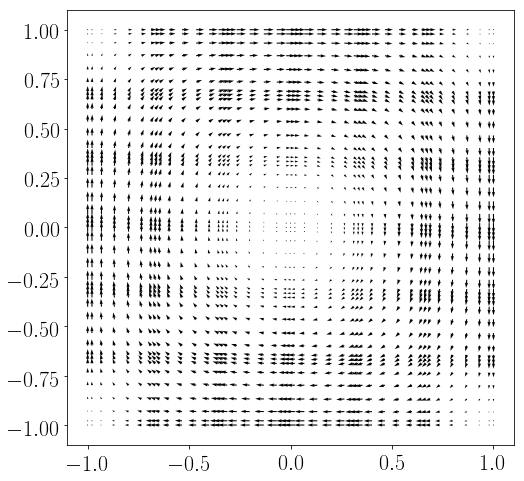

In [13]:
p0 = 7 # poly order
nl = p0 + 1
Ex = 6
Ey = 6 # multiple E, Ex x Ey
lxe = 2./float(Ex)
lye = 2./float(Ey)
mxlv = 10
# initflg:
#  1: 1D problem;  2: rotation field;  3:constant wind
#  4: pure diffusion; 5: varying boundary value
initflg = 2
(ah,bh,ch,dh,z,w) = sem.semhat(p0)
x = sem.semx(-1,1,Ex,p0,z)
y = sem.semx(-1,1,Ey,p0,z)
[X,Y] = np.meshgrid(x,y,indexing='ij')
[Nx,Ny] = X.shape
nu, cx, cy, bc = adf_coefs(initflg,X,Y)
t0 = time.time()
if(initflg!=4):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.quiver(X,Y,cx,cy,cmap=cm.gray)

[Qx,Rx] = sem.semqr(Ex,p0,bc.x.tostr())
[Qy,Ry] = sem.semqr(Ey,p0,bc.y.tostr())

cxl = Qx.dot(cx).dot(Qy.transpose())
cyl = Qx.dot(cy).dot(Qy.transpose())

cxle = ldir2elem(cxl,nl,Ex,Ey)
cyle = ldir2elem(cyl,nl,Ex,Ey)

# R, Q are direction based, while Lge, Bge are element based
R = sparse.kron(Ry,Rx)
Q = sparse.kron(Qy,Qx)

Lge, Bge = sem_adfglbop(p0,Ex,Ey,cxle,cyle,nu,lxe,lye)
Perm, P2 = genperm(p0+1,Ex,Ey)
Lgd = Lge[Perm,:][:,Perm]
Bgd = Bge[Perm,:][:,Perm]

Lg = R.dot(Q.transpose().dot(Lgd).dot(Q)).dot(R.transpose())
print(Lg.shape, Lg.nnz)
if(initflg==1):
    uex, fex = constant_case1(X,Y,nu)
    rhs = R.dot(Q.transpose()).dot(Bgd).dot(Q).dot(fex.reshape(-1,order='F'))
elif(initflg==2):
    Ub = 0. * X
    ind = np.where(abs(X-1.)<1.e-8)
    Ub[ind] = 1.
    rhs = - R.dot(Q.transpose().dot(Lgd).dot(Q).dot(Ub.reshape(-1,order='F')))
elif(initflg==3):
    uex, fex = constant_exc(X,Y,nu,cx[0,0],cy[0,0])
    rhs = R.dot(Q.transpose()).dot(Bgd).dot(Q).dot(fex.reshape(-1,order='F'))
elif(initflg==4):
    fex = 1. + 0.*X
    rhs = R.dot(Q.transpose()).dot(Bgd).dot(Q).dot(fex.reshape(-1,order='F'))
elif(initflg==5):
    Ub = 0. * X
    ind1 = np.where(abs(X-1.)<1.e-8)
    ind2 = np.where(abs(X+1.)<1.e-8)
    Ub[ind1] = 1.-np.cos(np.pi*Y[ind1])
    Ub[ind2] = 1.-np.cos(np.pi*Y[ind2])
    rhs = - R.dot(Q.transpose().dot(Lgd).dot(Q).dot(Ub.reshape(-1,order='F')))

In [14]:
## Direct solve
t0 = time.time()
Lglu = sla.splu(Lg.tocsc())
usln1 = Lglu.solve(rhs)
t1 = time.time() - t0
print('SP LU: time=%f'%(t1))

## GMRES solve
res2 = []
t0 = time.time()
# usln2,info,niter = gmressolve(Lg,rhs,tol=1e-8)
usln2, info = gmres(Lg,rhs,x0=None,tol=1e-8,restrt=200, maxiter=5,residuals=res2)
t2 = time.time() - t0
print('GMRES: time=%f, iter=%d, (start, end) res=%e,%e'%(t2, len(res2), res2[0],res2[-1]))

SP LU: time=0.026509
GMRES: time=0.841165, iter=1001, (start, end) res=1.107510e-01,3.764321e-04


In [15]:
def semml_smoother(Le,Be,Ll,e,nl,kind,bcel):
    '''Smoother choice'''
    # Will be singular for unassembled L
    if(kind=='SC'): # Schwarz
        ii = e*nl*nl
        ij = ii + nl*nl
        inde = np.arange(ii,ij)
        S = Ll[inde,:][:,inde]
        Sa = S.toarray() # inefficient, but small matrix
        sr = bcel.tostr()
        ind = []
        for pos, char in enumerate(sr):
            if char == 'd':
                ind.extend(fidtovid(pos,nl).tolist()) #
        list_set = set(ind)
        ind = (list(list_set)) # unique indices
        for ir in ind:
            Sa[ir,:] = 0.*Sa[ir,:]
            Sa[:,ir] = 0.*Sa[:,ir]
            Sa[ir,ir] = 1.
        S = sparse.csc_matrix(Sa)
        Sinv = sla.splu(S)
    elif(kind=='RR'): # Robin-Robin
        # issues with this: 1. does not work for pure diffusion
        #                   2. behaves worse compared to SC
        Sa = Le.copy().toarray()
        sr = bcel.tostr()
        ind = []
        inr = []
        for pos, char in enumerate(sr):
            if(char=='R'):
                inr.extend(fidtovid(pos,nl).tolist()) # track Robin
            elif(char=='d'):
                ind.extend(fidtovid(pos,nl).tolist()) #
        list_set = set(ind)
        ind = list(list_set) # unique indices
        list_set = set(inr)
        inr = list(list_set)
        for ir in inr:
            Sa[ir,ir] = Sa[ir,ir] + np.sqrt(Be[ir,ir]) # need: the normal velocity, the real surface integral
        for ir in ind:
            Sa[ir,:] = 0.*Sa[ir,:]
            Sa[:,ir] = 0.*Sa[:,ir]
            Sa[ir,ir] = 1.
        S = sparse.csc_matrix(Sa)
        Sinv = sla.splu(S.tocsc())
    else:
        print('Semml_smoother:: unknown smoother kind')
        return None
        
    return Sinv

class semml_md:
    '''SEM Multilevel structure in multidimension'''
    def __init__(self,p0,Ex,Ey,mxlv,initflg,X,Y,smoother=None,schedule=None,crs_solver=None):
        if(smoother is None):
            smoother = 'SC'
        if(schedule is None):
            schedule = ('Divide',2)
        if(crs_solver is None):
            crs_solver = 'SPLU'
        self.smoother = smoother
        self.schedule = schedule
        self.crs_solver = crs_solver
        if(self.schedule[0]=='Divide'):
            lv = min(mxlv,int(np.log(p0/1)/np.log(self.schedule[1]))+1)
        elif(self.schedule[0]=='Subtract'):
            lv = min(mxlv,int( (p0-1)/self.schedule[1]) + 1)
        self.lv = lv
        self.p0 = p0
        nu, cx, cy, self.bc = adf_coefs(initflg,X,Y)
        bcx = self.bc.x.tostr()
        bcy = self.bc.y.tostr()
        self.ne = (Ex,Ey)
        E = Ex*Ey
        self.Ne = E 
        pl,al,bl,cl,dl,zl,wl,Ql,Rl,xl,yl,jhl,jhfcl = ([] for i in range(13))
        lxe = 2./ float(Ex) # length in one direction
        lye = 2./ float(Ey)
        bce0 = setbce(Ex,Ey) # elementwise boundary conditions
        
        Ie = sparse.eye(E)
        Rel, Sel, Lel, Lgl, Bgl = ([] for i in range(5))
        for i in range(lv):
            if(self.schedule[0]=='Divide'):
                p = int(p0/(pow(self.schedule[1],i)))  # Faster schedule
            elif(self.schedule[0]=='Subtract'):
                p = p0-self.schedule[1]*i # Slow schedule
            if(p<2):
                p = 1
            if((p==1) and (i!=lv-1)):
                print('too many lvs, mxlv=%d'%mxlv)
                exit()
            pl.append(p)
            ah,bh,ch,dh,z,w = sem.semhat(p)
            al.append(ah)
            bl.append(bh)
            cl.append(ch)
            dl.append(dh)
            zl.append(z)
            wl.append(w)
            [Qx,Rx] = sem.semqr(Ex,p,bcx)
            [Qy,Ry] = sem.semqr(Ey,p,bcy)
            Ql.append(sparse.kron(Qy,Qx).tocsr())
            Rl.append(sparse.kron(Ry,Rx).tocsr())
            if(i==0):
                cxd = Qx.dot(cx).dot(Qy.transpose())
                cyd = Qx.dot(cy).dot(Qy.transpose())
                cxe = ldir2elem(cxd,p+1,Ex,Ey)
                cye = ldir2elem(cyd,p+1,Ex,Ey)
                cxl = [cxe]
                cyl = [cye]
            if(i>=1):
                jh   = sem.interp_mat(zl[i-1],zl[i]) # coarse to fine
                jhfc = sem.interp_mat(zl[i],zl[i-1]) # fine to coarse
                jhl.append(jh)
                jhfcl.append(jhfc)
                cxt = np.zeros((p+1,p+1,E))
                cyt = np.zeros((p+1,p+1,E))
                for e in range(E):
                    cxt[:,:,e] = jhfc.dot(cxl[i-1][:,:,e]).dot(jhfc.transpose())
                    cyt[:,:,e] = jhfc.dot(cyl[i-1][:,:,e]).dot(jhfc.transpose())
                cxl.append(cxt)
                cyl.append(cyt)

            if(self.smoother=='SC'):
                bce = bce0
            elif(self.smoother=='RR'):
                bce = setbce_RR(bce0,Ex,Ey,cxl[i],cyl[i],w,p+1)
                
            Re, Se = ([] for ii in range(2))
            Lge, Bge = sem_adfglbop(p,Ex,Ey,cxl[i],cyl[i],nu,lxe,lye)
            Perm, P2 = genperm(p+1,Ex,Ey)
            Lgd = Lge[Perm,:][:,Perm]
            Bgd = Bge[Perm,:][:,Perm]
            R = Rl[i]
            Q = Ql[i]
            # This is hacky !!
            Ll = (Q.dot(Q.transpose().dot(Lgd).dot(Q)).dot(Q.transpose()))
            Ll = Ll[P2,:][:,P2]

            for e in range(E):
                # print(i,e,bce[e].tostr())
                _,be,_,Le = sem_adflocop(al[i],bl[i],dl[i],cxl[i][:,:,e],cyl[i][:,:,e],nu,lxe,lye)
                Se.append(semml_smoother(Le,be,Ll,e,p+1,self.smoother,bce[e])) # Elementwise smoother
                Re.append(np.eye(Le.shape[0]))              # Elementwise restriction

            Rel.append(Re)
            Sel.append(Se)
            
            Lel.append(Le)
            Lg = R.dot(Q.transpose().dot(Lgd)).dot(Q.dot(R.transpose()))
            Bg = R.dot(Q.transpose().dot(Bgd.dot(Q)).dot(R.transpose()))
            Lgl.append(Lg)
            Bgl.append(Bg)
            
        # Coarse grid solver
        self.crssolve = sla.splu(Lgl[-1].tocsc())
        self.xl = xl
        self.pl = pl
        self.jhl = jhl
        self.jhfcl = jhfcl
        self.Ql = Ql
        self.Rl = Rl
        self.Sel = Sel
        self.Rel = Rel
        self.Lgl = Lgl
        self.Bgl = Bgl
    
    def __repr__(self):
        output = 'SEM Multigrid:\n'
        output += 'leves: %d\n'%(self.lv)
        output += 'Smoother: %s\n'%self.smoother
        output += 'Schedule: %s by %d\n'%(self.schedule[0],self.schedule[1])
        output += 'Level   Poly Order    Unknowns\n'
        for i in range(self.lv):
            output += '   %2d          %3d  %10d\n'\
                       %(i, self.pl[i], self.Lgl[i].shape[0])
        return output

    def solve(self,r):
        '''Perform one V(1,0) cycle'''
        E = self.Ne
        Ex,Ey = self.ne
        Ie = np.eye(E)
        mxv = 1
        mxsmth = 1
        sigma = 0.25
        u = 0.*r
        lv = self.lv
        for img in range(mxv):
            rhs = r - self.Lgl[0].dot(u)
            usln = []
            for il in range(lv-1):  ## down
                p  = self.pl[il]
                nl = p + 1 # number of points
                Se = self.Sel[il]
                Re = self.Rel[il]
                Q  = self.Ql[il]
                R  = self.Rl[il]
                Lg = self.Lgl[il]
                rd  = Q.dot(R.transpose().dot(rhs))
                re  = ldir2elem(rd.reshape((nl*Ex,nl*Ey),order='F'),nl,Ex,Ey).reshape(-1,order='F')
                ulv = 0.*rhs    # global
                dul = 0.*re     # local
                for i in range(mxsmth):
                    j = 0
                    for ie in range(E):
                        dul[j:j+nl*nl] = Se[ie].solve(re[j:j+nl*nl])
                        dul[j:j+nl*nl] = Re[ie].dot(dul[j:j+nl*nl])
                        j = j + nl*nl
                    dud = elem2ldir(dul.reshape((nl,nl,E),order='F'),nl,Ex,Ey).reshape(-1,order='F')
                    du = R.dot(Q.transpose().dot(dud))
                    ulv = ulv + sigma*du
                    rd = Q.dot(R.transpose().dot(rhs - Lg.dot(ulv)))
                usln.append(Q.dot(R.transpose().dot(ulv)))
                jh  = self.jhl[il]
                jht = jh.transpose()
                nc = jht.shape[0]
                re = ldir2elem(rd.reshape((nl*Ex,nl*Ey),order='F'),nl,Ex,Ey)#.reshape(-1,order='F')
                rce = np.zeros((nc,nc,E))
                for ie in range(E):
                    rce[:,:,ie]  = jht.dot(re[:,:,ie]).dot(jh)  # Elementwise, local
                rl = elem2ldir(rce,nc,Ex,Ey).reshape(-1,order='F')
                rhs = self.Rl[il+1].dot(self.Ql[il+1].transpose().dot(rl))  # global
            
            ucrs = self.crssolve.solve(rhs) ## crs solve
            usln.append(self.Ql[lv-1].dot(self.Rl[lv-1].transpose().dot(ucrs)))

            for il in range(lv-1,0,-1): ## up leg for multilevel
                jh = self.jhl[il-1]
                Q = self.Ql[lv-1]
                R = self.Rl[lv-1]
                nf = jh.shape[0]
                nc = jh.shape[1]
                uinte = np.zeros((nf,nf,E))
                uslne = ldir2elem(usln[il].reshape((nc*Ex,nc*Ey),order='F'),nc,Ex,Ey)
                for ie in range(E):
                    uinte[:,:,ie] = jh.dot(uslne[:,:,ie]).dot(jh.transpose())
                uintl = elem2ldir(uinte,nf,Ex,Ey).reshape(-1,order='F')   
                usln[il-1] = usln[il-1] + uintl  # just save local solution!
            ul = usln[0]

            # find u based on ul - not implemented yet
            # u = dsavg(ul)
            u = u + self.Rl[0].dot(self.Ql[0].transpose().dot(ul))
            ul = self.Ql[0].dot(self.Rl[0].transpose().dot(u))

        return u
    
    def smooth(self,r,x0,mxsmth):
        '''Check whether the smoother reduce high wavenumber error'''
        E = self.Ne
        Ex,Ey = self.ne
        sigma = 1.
        u = x0
        rhs = r - self.Lgl[0].dot(u)
        ulcl,uglb = ([] for i in range(2))
        p  = self.pl[0]
        nl = p + 1 # number of points
        Se = self.Sel[0]
        Re = self.Rel[0]
        Q  = self.Ql[0]
        R  = self.Rl[0]
        Lg = self.Lgl[0]
        rd  = Q.dot(R.transpose().dot(rhs))
        re  = ldir2elem(rd.reshape((nl*Ex,nl*Ey),order='F'),nl,Ex,Ey).reshape(-1,order='F')
        ulv = 0.*rhs    # global
        dul = 0.*re     # local
        for im in range(mxsmth):
            j = 0
            for ie in range(E):
                dul[j:j+nl*nl] = Se[ie].solve(re[j:j+nl*nl])
                dul[j:j+nl*nl] = Re[ie].dot(dul[j:j+nl*nl])
                j = j + nl*nl
            dud = elem2ldir(dul.reshape((nl,nl,E),order='F'),nl,Ex,Ey).reshape(-1,order='F')
            du = R.dot(Q.transpose().dot(dud))
            ulv = ulv + sigma*du
            rd = Q.dot(R.transpose().dot(rhs - Lg.dot(ulv)))
            re  = ldir2elem(rd.reshape((nl*Ex,nl*Ey),order='F'),nl,Ex,Ey).reshape(-1,order='F')
            ulcl.append(Q.dot(R.transpose().dot(ulv))) # local, dir based soln
            uglb.append(ulv) # global, dir based soln
            print('Smoother test: %d, %f, %f\n'%(im,sl.norm(rd,2),sl.norm(ulv,2)))
        return ulcl, uglb

In [16]:
## MG setup
t0 = time.time()
# semml = semml_md(p0,Ex,Ey,mxlv,initflg,X,Y,smoother='SC',schedule=('Divide',2),crs_solver='SPLU')
semml = semml_md(p0,Ex,Ey,mxlv,initflg,X,Y,smoother='RR',schedule=('Divide',2),crs_solver='SPLU')

tmgsetup = time.time() - t0
print(semml, tmgsetup)

SEM Multigrid:
leves: 3
Smoother: RR
Schedule: Divide by 2
Level   Poly Order    Unknowns
    0            7        1681
    1            3         289
    2            1          25
 1.5729780197143555


In [17]:
r = np.copy(rhs)
r = np.zeros(rhs.shape) # exact soln 0
x0 = np.random.rand(rhs.shape[0],)
usmth = 0.*r
mxsm = 5
t0 = time.time()
_,uglb = semml.smooth(r,x0,mxsm)
# print('%4d %12.5g MG'%(iv, sl.norm(r,2)))
t3 = time.time() - t0
# print('Smooth: time=%f, iter=%d'%(t3, iv))

Smoother test: 0, 1.989529, 42.575606

Smoother test: 1, 6.906808, 125.151961

Smoother test: 2, 29.263748, 633.672224

Smoother test: 3, 148.788985, 3721.877600

Smoother test: 4, 863.403457, 23416.315395



<Figure size 432x288 with 0 Axes>

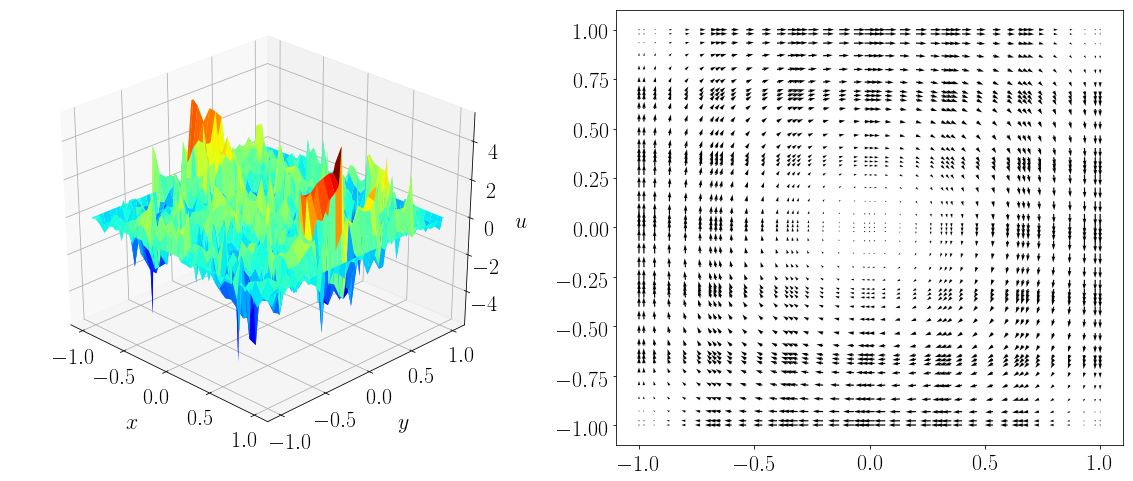

<Figure size 432x288 with 0 Axes>

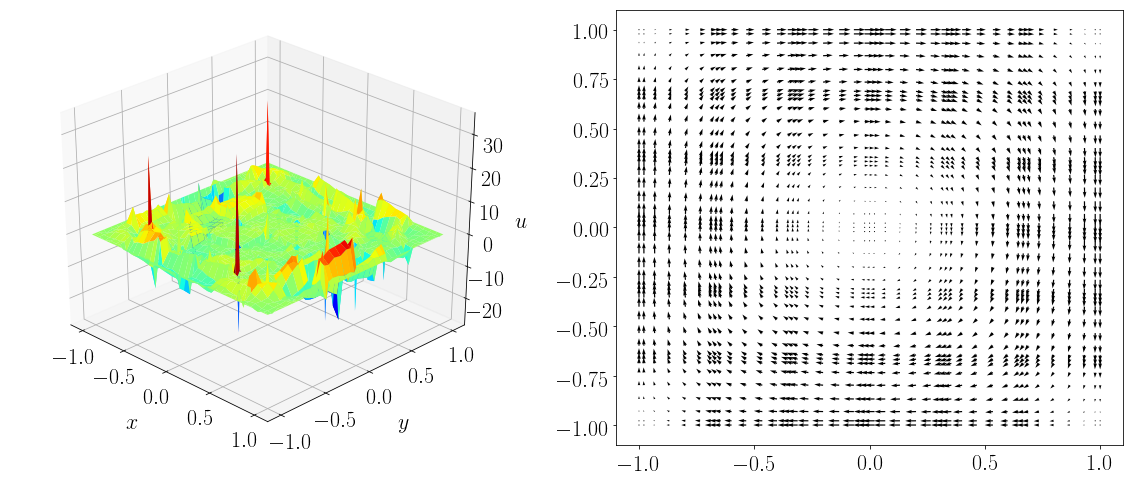

<Figure size 432x288 with 0 Axes>

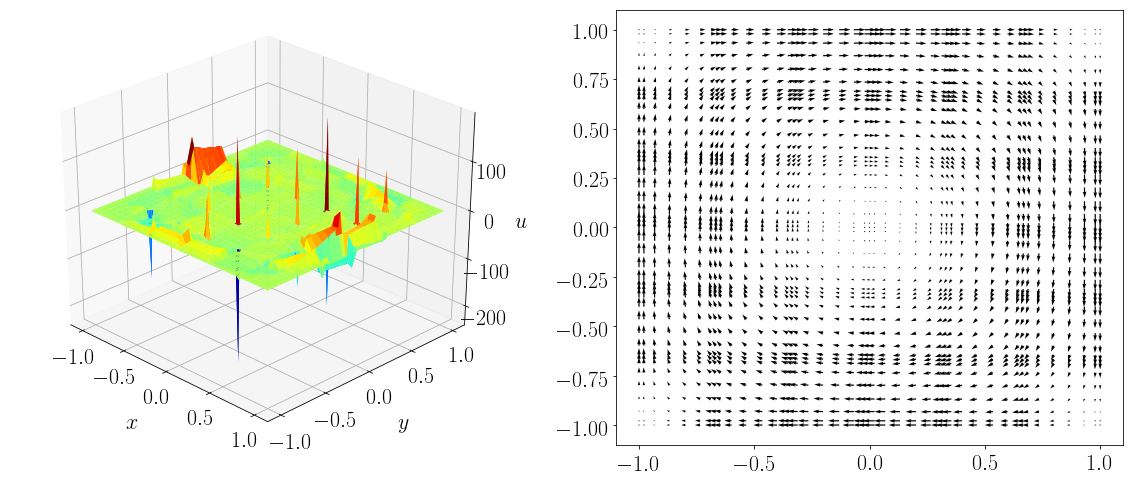

<Figure size 432x288 with 0 Axes>

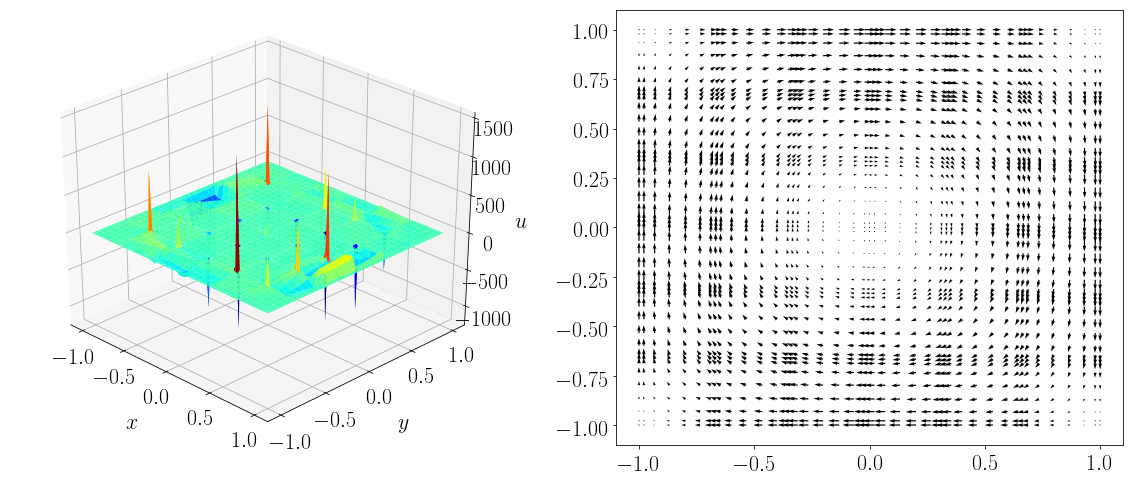

<Figure size 432x288 with 0 Axes>

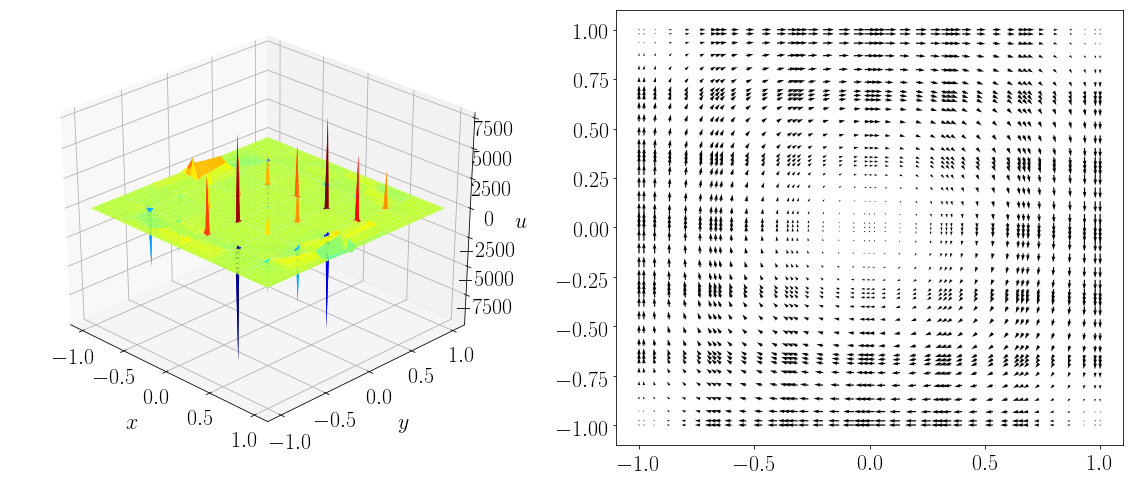

In [18]:
for im in range(len(uglb)):
    plt.figure()
    sempltsurf(X,Y,R.transpose().dot(uglb[im]).reshape(X.shape,order='F'),cx,cy,xyrot=315)

In [19]:
r = np.copy(rhs)
umg = 0.*r
mxv = 10
t0 = time.time()
for iv in range(mxv):
    z = semml.solve(r)
    umg = umg + z
    r = rhs - Lg.dot(umg)
    print('%4d %12.5g MG'%(iv, sl.norm(r,2)))
t3 = time.time() - t0
print('MG-Vc: time=%f, iter=%d'%(t3, iv))
usln3 = umg

   0      0.61262 MG
   1       23.604 MG
   2       992.46 MG
   3        42566 MG
   4   1.8379e+06 MG
   5   7.9492e+07 MG
   6   3.4392e+09 MG
   7    1.488e+11 MG
   8   6.4377e+12 MG
   9   2.7853e+14 MG
MG-Vc: time=0.180430, iter=9


In [20]:
## GMRES + MG
res4 = []
t0 = time.time()
Mz = lambda r: semml.solve(r)
Minv = sla.LinearOperator(Lg.shape, Mz)
# usln4,info,niter = gmressolve(Lg,rhs,tol=1.e-8,P=Minv) # scipy linalg gmres
usln4,info = gmres(Lg,rhs,x0=None,tol=1e-8,restrt=200, maxiter=5,M=Minv,residuals=res4) # pyamg krylov gmres
t4 = time.time()-t0
print('GMPMG: time=%f, iter=%d, (start, end) res=%e,%e'%(t4, len(res4), res4[0],res4[-1]))

GMPMG: time=2.092052, iter=158, (start, end) res=2.704880e+01,2.700570e-07


In [21]:
## MG setup
t0 = time.time()
semml = semml_md(p0,Ex,Ey,mxlv,initflg,X,Y,smoother='SC',schedule=('Divide',2),crs_solver='SPLU')
# semml = semml_md(p0,Ex,Ey,mxlv,initflg,X,Y,smoother='RR',schedule=('Divide',2),crs_solver='SPLU')

tmgsetup = time.time() - t0
print(semml, tmgsetup)

SEM Multigrid:
leves: 3
Smoother: SC
Schedule: Divide by 2
Level   Poly Order    Unknowns
    0            7        1681
    1            3         289
    2            1          25
 1.5288581848144531


In [22]:
## GMRES + MG
res4 = []
t0 = time.time()
Mz = lambda r: semml.solve(r)
Minv = sla.LinearOperator(Lg.shape, Mz)
# usln4,info,niter = gmressolve(Lg,rhs,tol=1.e-8,P=Minv) # scipy linalg gmres
usln4,info = gmres(Lg,rhs,x0=None,tol=1e-8,restrt=200, maxiter=5,M=Minv,residuals=res4) # pyamg krylov gmres
t4 = time.time()-t0
print('GMPMG: time=%f, iter=%d, (start, end) res=%e,%e'%(t4, len(res4), res4[0],res4[-1]))

GMPMG: time=1.873434, iter=139, (start, end) res=2.068165e+01,1.767173e-07


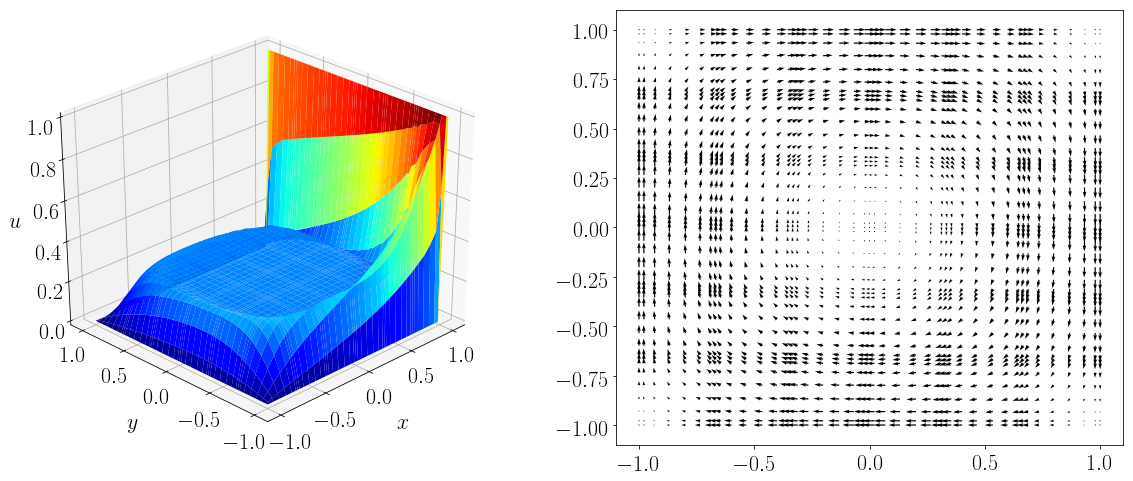

In [23]:
U0 = np.reshape(R.transpose().dot(usln4),(Nx,Ny),order='F')
if(initflg==1):
    print(p0,sl.norm((uex-U0).reshape(-1,order='F'),2))
    sempltsurf(X,Y,U0,cx,cy,xyrot=315)
elif(initflg==2):
    sempltsurf(X,Y,U0+Ub,cx,cy)
elif(initflg==3):
    print(p0,sl.norm((uex-U0).reshape(-1,order='F'),2))
    sempltsurf(X,Y,U0,cx,cy,xyrot=315)
elif(initflg==4):
    sempltsurf(X,Y,U0,cx,cy)
elif(initflg==5):
    sempltsurf(X,Y,U0+Ub,cx,cy)

# AMG Test

<class 'scipy.sparse.csr.csr_matrix'> (1681, 1681)


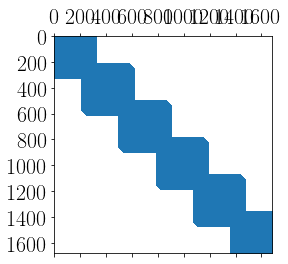

In [391]:
print(type(Lg),Lg.shape)
plt.spy(Lg)

In [392]:
bv = np.ones((Lg.shape[0],1))
t0 = time.time()
ml = pyamg.smoothed_aggregation_solver(Lg,symmetry="nonsymmetric",strength="symmetric",
                                       smooth=None,
                                       improve_candidates=None,
                                       presmoother='jacobi_ne', postsmoother='jacobi_ne')
# ml = pyamg.ruge_stuben_solver(Lg)
tamgsetup = time.time() - t0
print(ml,tamgsetup)

x0 = 0.*rhs
# x0 = np.random.rand(len(rhs))
residuals = []
t0 = time.time()
usln5 = ml.solve(b=rhs,x0=x0,tol=1e-8,residuals=residuals,maxiter=500,accel='gmres')
t5 = time.time() - t0
print('GMAMG: time=%f, iter=%d, (start,end res)=(%e, %e)'%(t5,len(residuals),residuals[0],residuals[-1]))

multilevel_solver
Number of Levels:     3
Operator Complexity:  1.014
Grid Complexity:      1.024
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0         1681        26937 [98.66%]
    1           36          352 [ 1.29%]
    2            4           14 [ 0.05%]
 0.026251792907714844
GMAMG: time=2.025241, iter=387, (start,end res)=(1.017390e+01, 9.886921e-08)


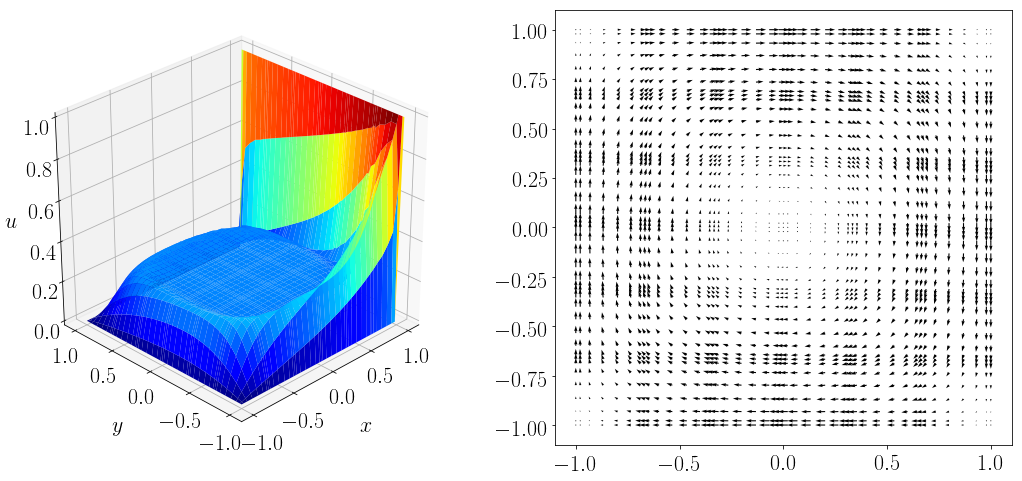

In [393]:
U0 = np.reshape(R.transpose().dot(usln5),(Nx,Ny),order='F')
if(initflg==2 or initflg==5):
    Usln = U0 + Ub
else:
    Usln = U0
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X,Y,Usln,cmap=cm.jet)
ax.set_xlabel('$x$',labelpad=20)
ax.set_ylabel('$y$',labelpad=20)
ax.set_zlabel('$u$',labelpad=10)
xyrot = 225
ax.view_init(30, xyrot)
ax2 = fig.add_subplot(122)
ax2.quiver(X,Y,cx,cy)

0

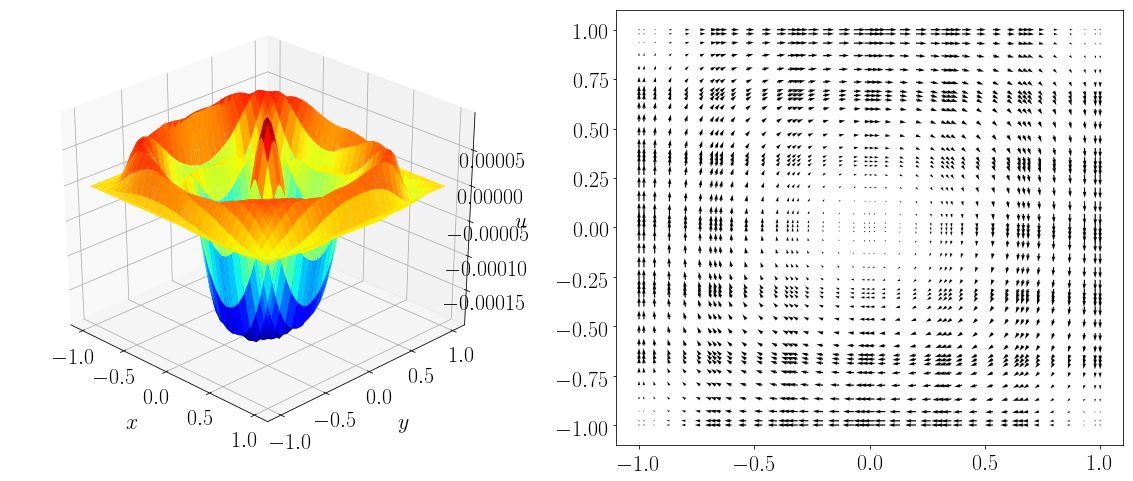

In [394]:
sempltsurf(X,Y,np.reshape(R.transpose().dot(usln4-usln5),(Nx,Ny),order='F'),cx,cy,xyrot=315)